In [13]:
import torch
import numpy as np
from sklearn.decomposition import PCA
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader
from numpy.core.multiarray import _reconstruct
import torch.serialization
from sklearn.metrics import classification_report


# Allowlist the _reconstruct function if you trust the source
torch.serialization.add_safe_globals([_reconstruct])

# Now attempt to load with weights_only=True
train_data, train_labels = torch.load('D:\\ASU\\Fall 2024\\EEE549\\Final term project\\sml-final\\data\\preprocessed\\cifar10\\preprocessed_train_cifar.pt', weights_only=False)
test_data, test_labels = torch.load('D:\\ASU\\Fall 2024\\EEE549\\Final term project\\sml-final\\data\\preprocessed\\cifar10\\preprocessed_test_cifar.pt', weights_only=False)


In [2]:
print(type(train_data))
print(isinstance(train_data, torch.Tensor))

<class 'numpy.ndarray'>
False


In [4]:
# Check the data types
print(f'Train Data Type: {type(train_data)}')
print(f'Test Data Type: {type(test_data)}')

# Assuming the data is loaded correctly and is indeed a Tensor
if isinstance(train_data, torch.Tensor) and isinstance(test_data, torch.Tensor):
    # Flatten the data and convert to numpy arrays for PCA
    X_train = train_data.view(train_data.size(0), -1).numpy()
    X_test = test_data.view(test_data.size(0), -1).numpy()
else:
    print("Data is not in tensor format.")

Train Data Type: <class 'numpy.ndarray'>
Test Data Type: <class 'numpy.ndarray'>
Data is not in tensor format.


In [5]:
if not isinstance(train_data, torch.Tensor):
    train_data = torch.tensor(train_data, dtype=torch.float)
if not isinstance(test_data, torch.Tensor):
    test_data = torch.tensor(test_data, dtype=torch.float)

In [6]:
# Flatten the data and convert to numpy arrays for PCA
X_train = train_data.view(train_data.size(0), -1).numpy()
X_test = test_data.view(test_data.size(0), -1).numpy()

# Apply PCA to reduce dimensions
pca = PCA(n_components=150)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Convert PCA data back to tensors for training
X_train_pca = torch.tensor(X_train_pca, dtype=torch.float)
X_test_pca = torch.tensor(X_test_pca, dtype=torch.float)
y_train = torch.tensor(train_labels, dtype=torch.long)
y_test = torch.tensor(test_labels, dtype=torch.long)

C:\Users\Aditya\AppData\Local\Temp\ipykernel_16976\1025937828.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(train_labels, dtype=torch.long)
C:\Users\Aditya\AppData\Local\Temp\ipykernel_16976\1025937828.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.long)


## PCA

In [7]:
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(150, 64)  # 150 features from PCA
        self.fc2 = nn.Linear(64, 10)   # Output 10 classes

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Create the neural network
model = SimpleNN()

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Data conversion and DataLoader setup
X_train_pca_tensor = torch.tensor(X_train_pca, dtype=torch.float)
y_train_tensor = torch.tensor(train_labels, dtype=torch.long)
X_test_pca_tensor = torch.tensor(X_test_pca, dtype=torch.float)
y_test_tensor = torch.tensor(test_labels, dtype=torch.long)

train_dataset = TensorDataset(X_train_pca_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_pca_tensor, y_test_tensor)
trainloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Function to calculate accuracy
def calculate_accuracy(model, data_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in data_loader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

# Train the model
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    train_acc = calculate_accuracy(model, trainloader)
    test_acc = calculate_accuracy(model, testloader)
    train_error = running_loss / len(trainloader)
    test_error = criterion(model(X_test_pca_tensor), y_test_tensor).item()

    print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_error:.4f}, Test Loss: {test_error:.4f}, Train Acc: {train_acc:.2f}%, Test Acc: {test_acc:.2f}%')


C:\Users\Aditya\AppData\Local\Temp\ipykernel_16976\14249072.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train_pca_tensor = torch.tensor(X_train_pca, dtype=torch.float)
C:\Users\Aditya\AppData\Local\Temp\ipykernel_16976\14249072.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(train_labels, dtype=torch.long)
C:\Users\Aditya\AppData\Local\Temp\ipykernel_16976\14249072.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test_pca_tensor = torch.tensor(X_test_pca, dtype=torch.float)
C:\Users\Adit

Epoch 1/100, Train Loss: 16.8998, Test Loss: 4.7178, Train Acc: 75.09%, Test Acc: 69.90%
Epoch 2/100, Train Loss: 3.0963, Test Loss: 3.1219, Train Acc: 78.13%, Test Acc: 71.60%
Epoch 3/100, Train Loss: 1.7408, Test Loss: 2.4493, Train Acc: 78.29%, Test Acc: 70.15%
Epoch 4/100, Train Loss: 1.0624, Test Loss: 1.7030, Train Acc: 84.16%, Test Acc: 73.00%
Epoch 5/100, Train Loss: 0.7137, Test Loss: 1.3637, Train Acc: 84.77%, Test Acc: 73.25%
Epoch 6/100, Train Loss: 0.5352, Test Loss: 1.2368, Train Acc: 82.73%, Test Acc: 73.30%
Epoch 7/100, Train Loss: 0.5074, Test Loss: 1.0536, Train Acc: 87.59%, Test Acc: 74.55%
Epoch 8/100, Train Loss: 0.3584, Test Loss: 1.0673, Train Acc: 85.29%, Test Acc: 72.15%
Epoch 9/100, Train Loss: 0.3359, Test Loss: 0.9216, Train Acc: 89.78%, Test Acc: 75.20%
Epoch 10/100, Train Loss: 0.3190, Test Loss: 0.9307, Train Acc: 90.10%, Test Acc: 74.25%
Epoch 11/100, Train Loss: 0.3204, Test Loss: 0.9912, Train Acc: 87.90%, Test Acc: 75.00%
Epoch 12/100, Train Loss: 0.2

## CNN

In [8]:
train_data = train_data.reshape((-1, 3, 32, 32))
test_data = test_data.reshape((-1, 3, 32, 32))

# Create TensorDatasets
train_dataset = TensorDataset(torch.tensor(train_data, dtype=torch.float), torch.tensor(train_labels, dtype=torch.long))
test_dataset = TensorDataset(torch.tensor(test_data, dtype=torch.float), torch.tensor(test_labels, dtype=torch.long))

# Create DataLoaders
trainloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

C:\Users\Aditya\AppData\Local\Temp\ipykernel_16976\3918409937.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_dataset = TensorDataset(torch.tensor(train_data, dtype=torch.float), torch.tensor(train_labels, dtype=torch.long))
C:\Users\Aditya\AppData\Local\Temp\ipykernel_16976\3918409937.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_dataset = TensorDataset(torch.tensor(test_data, dtype=torch.float), torch.tensor(test_labels, dtype=torch.long))


In [ ]:
# Assuming the original CIFAR-10 data has been loaded into train_data and test_data with proper image shapes
train_dataset = TensorDataset(torch.tensor(train_data.reshape(-1, 3, 32, 32), dtype=torch.float), torch.tensor(train_labels, dtype=torch.long))
test_dataset = TensorDataset(torch.tensor(test_data.reshape(-1, 3, 32, 32), dtype=torch.float), torch.tensor(test_labels, dtype=torch.long))

trainloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=64, shuffle=False)


class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=1, padding=2)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2)
        self.fc1 = nn.Linear(32 * 8 * 8, 120)
        self.fc2 = nn.Linear(120, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 32 * 8 * 8)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize CNN, loss function, and optimizer
cnn = CNN()
criterion_cnn = nn.CrossEntropyLoss()
optimizer_cnn = optim.Adam(cnn.parameters(), lr=0.001)

# Function to calculate accuracy
def calculate_accuracy(model, data_loader):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():
        for data in data_loader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    model.train()  # Switch back to training mode
    return 100 * correct / total

# Assuming trainloader and testloader are defined
# Training loop for CNN
# for epoch in range(10):
#     cnn.train()
#     running_loss = 0.0
#     for i, (inputs, labels) in enumerate(trainloader):
#         optimizer_cnn.zero_grad()
#         outputs = cnn(inputs)
#         loss = criterion_cnn(outputs, labels)
#         loss.backward()
#         optimizer_cnn.step()
#         running_loss += loss.item()

#     train_acc = calculate_accuracy(cnn, trainloader)
#     test_acc = calculate_accuracy(cnn, testloader)
#     train_loss = running_loss / len(trainloader)
#     test_loss = 0.0
#     for data in testloader:
#         images, labels = data
#         outputs = cnn(images)
#         loss = criterion_cnn(outputs, labels)
#         test_loss += loss.item()
#     test_loss /= len(testloader)

#     print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Train Acc: {train_acc:.2f}%, Test Acc: {test_acc:.2f}%')

# Ensure you are using the right DataLoader that provides image data in correct shape
# for epoch in range(10):
#     cnn.train()  # Set model to training mode
#     total_loss = 0
#     total = 0
#     correct = 0
#     for i, (inputs, labels) in enumerate(trainloader):
#         outputs = cnn(inputs)
#         loss = criterion_cnn(outputs, labels)
#         optimizer_cnn.zero_grad()
#         loss.backward()
#         optimizer_cnn.step()
#         total_loss += loss.item()

#         _, predicted = torch.max(outputs.data, 1)
#         total += labels.size(0)
#         correct += (predicted == labels).sum().item()

#     train_acc = 100 * correct / total
#     print(f'Epoch {epoch+1}: Loss={total_loss/len(trainloader)}, Train Acc={train_acc}%')


C:\Users\Aditya\AppData\Local\Temp\ipykernel_16976\501801529.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_dataset = TensorDataset(torch.tensor(train_data.reshape(-1, 3, 32, 32), dtype=torch.float), torch.tensor(train_labels, dtype=torch.long))
C:\Users\Aditya\AppData\Local\Temp\ipykernel_16976\501801529.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_dataset = TensorDataset(torch.tensor(test_data.reshape(-1, 3, 32, 32), dtype=torch.float), torch.tensor(test_labels, dtype=torch.long))


Epoch 1: Loss=1.0295965341246052, Train Acc=62.18%
Epoch 2: Loss=0.5443131652227633, Train Acc=72.56%
Epoch 3: Loss=0.49813217835821166, Train Acc=75.95%
Epoch 4: Loss=0.47547678981617, Train Acc=77.77%
Epoch 5: Loss=0.45086135131538296, Train Acc=78.86%
Epoch 6: Loss=0.4322556061729504, Train Acc=79.57%
Epoch 7: Loss=0.40970430062834623, Train Acc=81.0%
Epoch 8: Loss=0.3994718106688967, Train Acc=81.41%
Epoch 9: Loss=0.39146839775097597, Train Acc=82.27%
Epoch 10: Loss=0.3728148992274218, Train Acc=83.36%


In [19]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(10):
    cnn.train()
    total_train_loss = 0
    correct_train = 0
    total_train = 0
    
    for inputs, labels in trainloader:
        optimizer_cnn.zero_grad()
        outputs = cnn(inputs)
        loss = criterion_cnn(outputs, labels)
        loss.backward()
        optimizer_cnn.step()
        
        total_train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_accuracy = 100 * correct_train / total_train
    average_train_loss = total_train_loss / len(trainloader)

    cnn.eval()
    total_val_loss = 0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, labels in testloader:
            outputs = cnn(inputs)
            loss = criterion_cnn(outputs, labels)
            total_val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_accuracy = 100 * correct_val / total_val
    average_val_loss = total_val_loss / len(testloader)

    # Append metrics to lists
    train_losses.append(average_train_loss)
    val_losses.append(average_val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    print(f'Epoch {epoch+1}: Train Loss: {average_train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Validation Loss: {average_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')


Epoch 1: Train Loss: 0.1708, Train Accuracy: 93.40%, Validation Loss: 0.7100, Validation Accuracy: 77.15%
Epoch 2: Train Loss: 0.1679, Train Accuracy: 93.17%, Validation Loss: 0.7208, Validation Accuracy: 77.90%
Epoch 3: Train Loss: 0.1242, Train Accuracy: 95.22%, Validation Loss: 0.7757, Validation Accuracy: 77.35%
Epoch 4: Train Loss: 0.1173, Train Accuracy: 95.40%, Validation Loss: 0.8883, Validation Accuracy: 77.90%
Epoch 5: Train Loss: 0.1086, Train Accuracy: 95.84%, Validation Loss: 0.9222, Validation Accuracy: 77.50%
Epoch 6: Train Loss: 0.1312, Train Accuracy: 94.88%, Validation Loss: 0.9019, Validation Accuracy: 77.05%
Epoch 7: Train Loss: 0.0983, Train Accuracy: 96.28%, Validation Loss: 0.9858, Validation Accuracy: 76.40%
Epoch 8: Train Loss: 0.1008, Train Accuracy: 96.05%, Validation Loss: 0.9078, Validation Accuracy: 78.00%
Epoch 9: Train Loss: 0.0814, Train Accuracy: 97.01%, Validation Loss: 0.9198, Validation Accuracy: 77.95%
Epoch 10: Train Loss: 0.0521, Train Accuracy: 

In [16]:
for inputs, labels in trainloader:
    print("Shape of CNN inputs:", inputs.shape)  # Should output [64, 3, 32, 32] or similar
    break 

Shape of CNN inputs: torch.Size([64, 3, 32, 32])


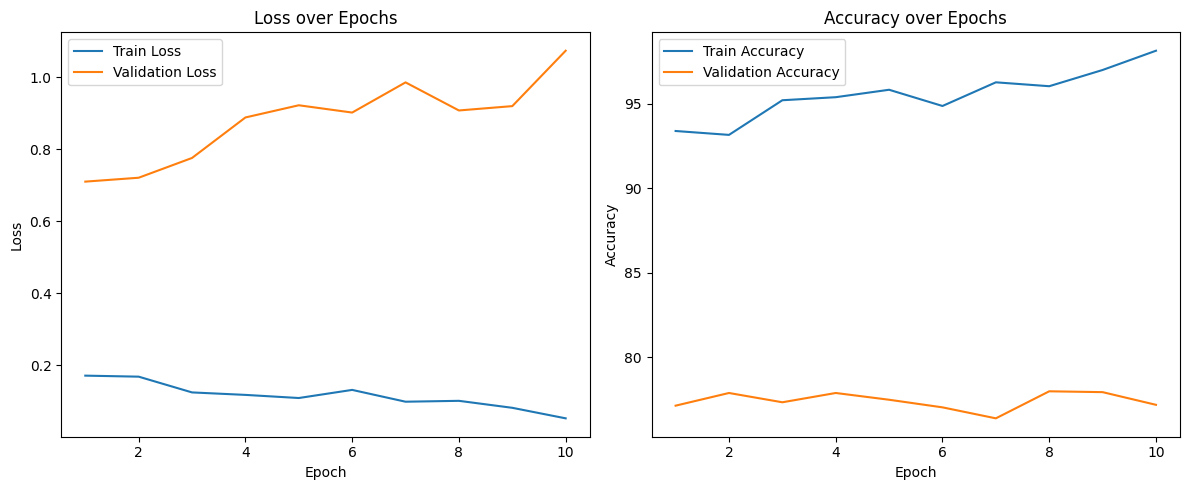

In [20]:
import matplotlib.pyplot as plt

epochs = range(1, 11)  # Adjust depending on the number of epochs

plt.figure(figsize=(12, 5))

# Plot for Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot for Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


## Classification report

In [11]:
# Ensure PCA data is converted to tensors properly
X_train_pca_tensor = torch.tensor(X_train_pca, dtype=torch.float32)
X_test_pca_tensor = torch.tensor(X_test_pca, dtype=torch.float32)


C:\Users\Aditya\AppData\Local\Temp\ipykernel_16976\4182289895.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train_pca_tensor = torch.tensor(X_train_pca, dtype=torch.float32)
C:\Users\Aditya\AppData\Local\Temp\ipykernel_16976\4182289895.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test_pca_tensor = torch.tensor(X_test_pca, dtype=torch.float32)


In [12]:
# Set up TensorDatasets and DataLoaders for PCA model
train_dataset = TensorDataset(X_train_pca_tensor, torch.tensor(train_labels, dtype=torch.long))
test_dataset = TensorDataset(X_test_pca_tensor, torch.tensor(test_labels, dtype=torch.long))

trainloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

C:\Users\Aditya\AppData\Local\Temp\ipykernel_16976\599410454.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_dataset = TensorDataset(X_train_pca_tensor, torch.tensor(train_labels, dtype=torch.long))
C:\Users\Aditya\AppData\Local\Temp\ipykernel_16976\599410454.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_dataset = TensorDataset(X_test_pca_tensor, torch.tensor(test_labels, dtype=torch.long))


In [14]:
def get_predictions(model, data_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in data_loader:
            print("Input shape:", inputs.shape)  # Debug: Check input shape
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.numpy())
            all_labels.extend(labels.numpy())
    return all_preds, all_labels


# Get predictions from PCA model
pca_preds, pca_labels = get_predictions(model, testloader)
# Get predictions from CNN model
cnn_preds, cnn_labels = get_predictions(cnn, testloader)

# Print classification report
print("Classification Report for PCA Model:")
print(classification_report(pca_labels, pca_preds))
print("Classification Report for CNN Model:")
print(classification_report(cnn_labels, cnn_preds))

Input shape: torch.Size([64, 150])
Input shape: torch.Size([64, 150])
Input shape: torch.Size([64, 150])
Input shape: torch.Size([64, 150])
Input shape: torch.Size([64, 150])
Input shape: torch.Size([64, 150])
Input shape: torch.Size([64, 150])
Input shape: torch.Size([64, 150])
Input shape: torch.Size([64, 150])
Input shape: torch.Size([64, 150])
Input shape: torch.Size([64, 150])
Input shape: torch.Size([64, 150])
Input shape: torch.Size([64, 150])
Input shape: torch.Size([64, 150])
Input shape: torch.Size([64, 150])
Input shape: torch.Size([64, 150])
Input shape: torch.Size([64, 150])
Input shape: torch.Size([64, 150])
Input shape: torch.Size([64, 150])
Input shape: torch.Size([64, 150])
Input shape: torch.Size([64, 150])
Input shape: torch.Size([64, 150])
Input shape: torch.Size([64, 150])
Input shape: torch.Size([64, 150])
Input shape: torch.Size([64, 150])
Input shape: torch.Size([64, 150])
Input shape: torch.Size([64, 150])
Input shape: torch.Size([64, 150])
Input shape: torch.S

RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv2d, but got input of size: [64, 150]

In [21]:
from sklearn.metrics import classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np
import matplotlib.pyplot as plt

# Assuming the number of classes is known
num_classes = 10
# Binarize the labels for ROC curve multiclass handling
y_test_bin = label_binarize(test_labels, classes=[i for i in range(num_classes)])

# Collect predictions and probabilities
cnn.eval()
y_pred = []
y_score = []

with torch.no_grad():
    for inputs, labels in testloader:
        outputs = cnn(inputs)
        # For ROC curve, we need the score, not the hard predictions
        softmax_scores = torch.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs, 1)
        
        y_pred.extend(predicted.cpu().numpy())
        y_score.extend(softmax_scores.cpu().numpy())

# Convert collected scores and predicted labels to numpy arrays
y_score = np.array(y_score)
y_pred = np.array(y_pred)

# Generate classification report
print("Classification Report for CNN Model:")
print(classification_report(test_labels, y_pred))


Classification Report for CNN Model:
              precision    recall  f1-score   support

           0       0.76      0.80      0.78      1000
           1       0.79      0.74      0.77      1000

    accuracy                           0.77      2000
   macro avg       0.77      0.77      0.77      2000
weighted avg       0.77      0.77      0.77      2000



## ROC Plots

## CNN

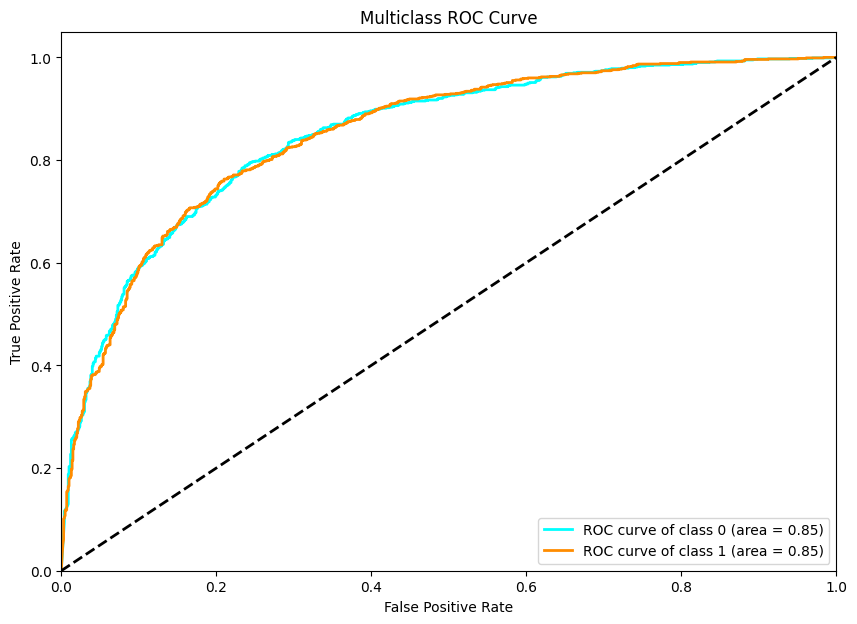

In [25]:
from itertools import cycle
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import numpy as np

def plot_multiclass_roc(y_test, y_score, classes, figsize=(10, 7)):
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    # Setup figure and color cycle
    plt.figure(figsize=figsize)
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive'])

    for i, color in zip(range(len(classes)), colors):
        # Handle classes with no positive samples
        if np.sum(y_test[:, i]) == 0:
            continue
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i], color=color, lw=2, label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multiclass ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

# Example usage with y_test_bin and y_score
plot_multiclass_roc(y_test_bin, y_score, classes=[i for i in range(num_classes)])
